# LSTM Model

##Install the necessary libraries

In [1]:
!pip install tensorflow keras-tuner pandas scikit-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


## Importing all the libraries

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_tuner import RandomSearch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

## Loading Data

In [3]:
# Load data
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

# Combine for consistent preprocessing
full_texts = pd.concat([train_data['full_text'], test_data['full_text']], axis=0)

# Tokenize text
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(full_texts)
train_sequences = tokenizer.texts_to_sequences(train_data['full_text'])
test_sequences = tokenizer.texts_to_sequences(test_data['full_text'])

# Pad sequences
max_length = 500
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

## Building Model and Loading training and testing data

In [4]:
def build_model(hp):
    model = Sequential([
        Embedding(input_dim=5000, output_dim=64, input_length=max_length),
        LSTM(hp.Int('units', min_value=64, max_value=256, step=32), return_sequences=True),
        Dropout(0.5),
        LSTM(hp.Int('units', min_value=64, max_value=256, step=32)),
        Dense(1, activation='linear')
    ])
    model.compile(
        loss='mean_squared_error',
        optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        metrics=['mean_squared_error']
    )
    return model

X_train, X_val, y_train, y_val = train_test_split(train_padded, train_data['score'], test_size=0.2, random_state=42)

## Setting up the Hyperparameter Tuner

In [5]:
tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error',
    max_trials=5,
    executions_per_trial=1,
    directory='model_tuning',
    project_name='EssayScoring'
)

## Callbacks

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_dir = './model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
model_checkpoint = ModelCheckpoint(
    os.path.join(checkpoint_dir, 'best_model.h5'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

## Training Process

In [7]:
tuner.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])

Trial 5 Complete [00h 08m 09s]
val_mean_squared_error: 0.3894566595554352

Best val_mean_squared_error So Far: 0.3894566595554352
Total elapsed time: 00h 45m 13s


## Getting the Best Model

In [8]:
best_model = tuner.get_best_models(num_models=1)[0]

In [9]:
best_model_path = os.path.join(checkpoint_dir, 'best_model.h5')
best_model.load_weights(best_model_path)

## Evaluating the Best Model

In [10]:
loss, mse = best_model.evaluate(X_val, y_val)
print(f'Validation MSE: {mse}')

109/109 [==============================] - 3s 18ms/step - loss: 0.3895 - mean_squared_error: 0.3895
Validation MSE: 0.3894566595554352


## Predicting Test Score

In [11]:
predicted_scores = best_model.predict(test_padded).flatten()
predicted_scores = np.round(predicted_scores).astype(int)

1/1 [==============================] - 1s 1s/step


In [12]:
submission = pd.DataFrame({'essay_id': test_data['essay_id'], 'score': predicted_scores})
submission.to_csv('submission.csv', index=False)

## Graph Preparation

In [14]:
# If you are evaluating against the validation set
predicted_scores = best_model.predict(X_val).flatten()
predicted_scores = np.round(predicted_scores).astype(int)
actual_scores = y_val  # This should be from the same set as the X used in predict()
predicted_scores = best_model.predict(X_val).flatten()  # Make sure to predict on the same X
predicted_scores = np.round(predicted_scores).astype(int)

109/109 [==============================] - 2s 14ms/step


## Confusion Matrix

The confusion matrix is a useful diagnostic tool in classification, although less common in regression tasks, it can be adapted by binning continuous output. It provides a visual representation of where the model is confusing one label for another. Each cell in the matrix represents the number of instances where the predicted label was x and the actual label was y.

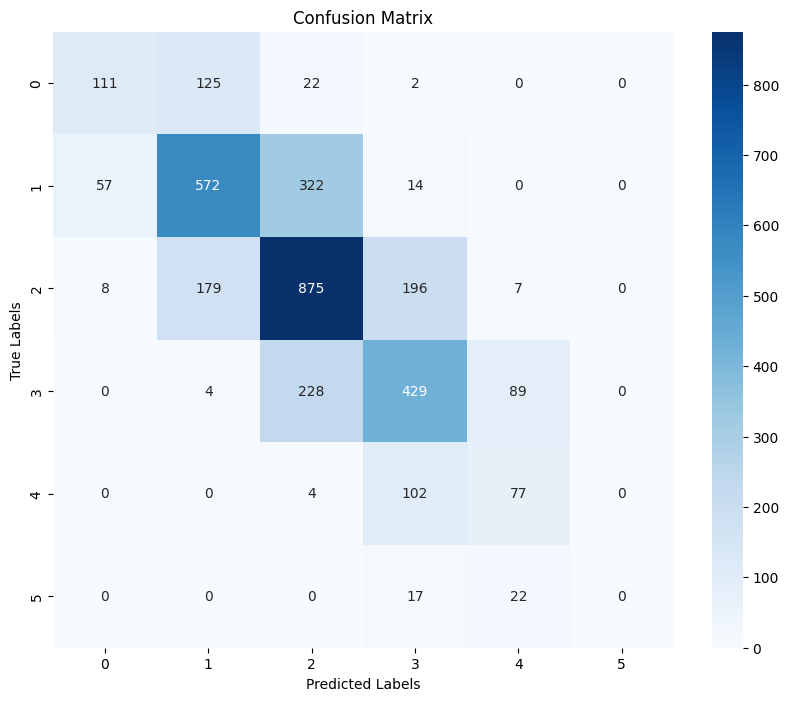

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

bins = np.linspace(min(min(actual_scores), min(predicted_scores)), max(max(actual_scores), max(predicted_scores)), num=10)
binned_actual = np.digitize(actual_scores, bins)
binned_predicted = np.digitize(predicted_scores, bins)

conf_mat = confusion_matrix(binned_actual, binned_predicted)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Error Histogram

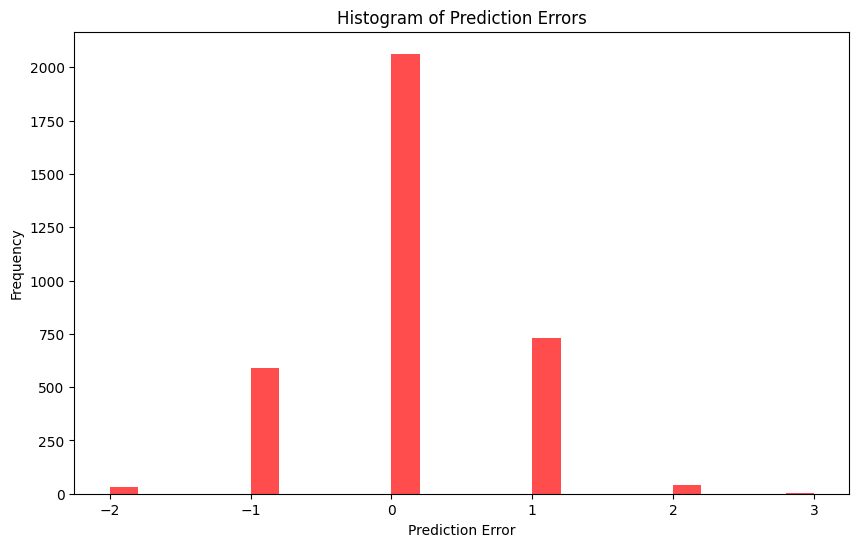

In [16]:
errors = predicted_scores - actual_scores
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=25, color='red', alpha=0.7)
plt.title('Histogram of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

## Scatter Plot of Predictions vs. Actuals

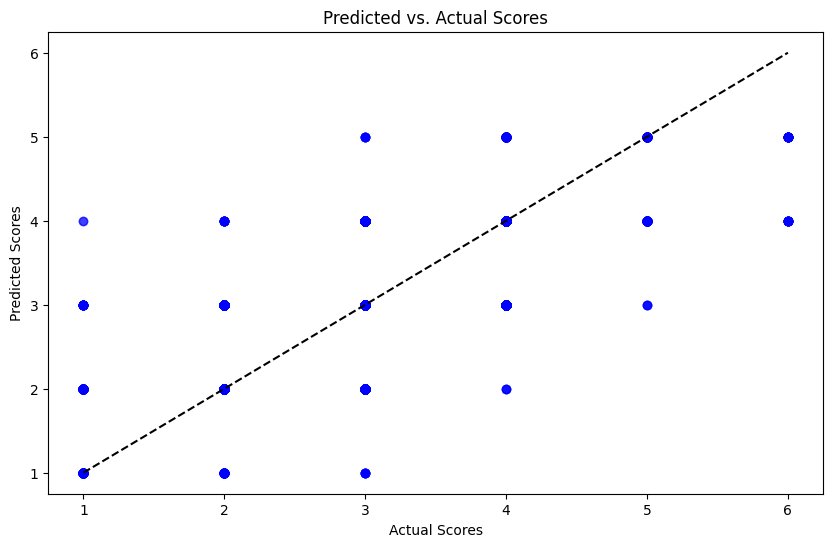

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(actual_scores, predicted_scores, alpha=0.5, color='blue')
plt.title('Predicted vs. Actual Scores')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.plot([min(actual_scores), max(actual_scores)], [min(actual_scores), max(actual_scores)], 'k--')  # Identity line
plt.show()